# ASSURE-US Machine Learning Project - Climate Change

Data used:
* http://scrippsco2.ucsd.edu/data/atmospheric_co2/icecore_merged_products
* https://data.giss.nasa.gov/gistemp/
* ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt

In [171]:
MONTH_DICT = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov":11, "Dec": 12
}

BASE_TEMP = 14 # See: https://data.giss.nasa.gov/gistemp/faq/abs_temp.html

In [172]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(tf.VERSION)

1.13.1


In [173]:
dataset = pd.read_csv(
    "./GLB.Ts+dSST.csv",
    ",",
    na_values=["***"],
    skiprows=1,
    usecols=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Year"]
)

# Duplicate rows for each month
dataset = dataset.melt(id_vars=["Year"], var_name="Month", value_name="Temp")

# Convert month names into numeric values
dataset["Month"] = dataset["Month"].map(MONTH_DICT)

# Sort by year and then month
dataset = dataset.sort_values(["Year", "Month"])
dataset = dataset.reset_index(drop=True)

# Clean up dataset
dataset = dataset.dropna()

# Convert to absolute temperatures (GISS works in temperature anomaly)
dataset["Temp"] = dataset["Temp"].add(BASE_TEMP)

dataset.tail()

,Year,Month,Temp
1667,2018,12,14.89
1668,2019,1,14.87
1669,2019,2,14.90
1670,2019,3,15.11
1671,2019,4,14.99


In [174]:
# Load information about CO2 concentration
co2_data = pd.read_csv(
    "./co2_mm_gl.txt",
    delim_whitespace=True,
    comment='#',
    names=["Year", "Month", "CO2"],
    na_values=[-99.99],
    usecols=[0, 1, 3]
)

# Load lower resolution (yearly instead of monthly) data to fill in previous years
co2_old_data = pd.read_csv("spline_merged_ice_core_yearly.csv", comment="\"", names=["Year", "CO2"])
co2_old_data = co2_old_data.loc[co2_old_data.index.repeat(12)].reset_index(drop=True)
co2_old_data.insert(0, "Month", (co2_old_data.index % 12) + 1)

# Merge the old data with the new data: https://stackoverflow.com/a/44784056
co2_data = pd.concat([co2_old_data, co2_old_data, co2_data], axis=0, sort=False)
co2_data = co2_data.reset_index(drop=True)

co2_data.tail()

,Month,Year,CO2
48897,10,2018,406.40
48898,11,2018,407.88
48899,12,2018,408.98
48900,1,2019,409.82
48901,2,2019,410.60


In [175]:
# Load information about CH4 concentration
ch4_data = pd.read_csv(
    "./ch4_mm_gl.txt",
    delim_whitespace=True,
    comment='#',
    names=["Year", "Month", "CH4"],
    na_values=[-99.99],
    usecols=[0, 1, 3]
)

ch4_old_data = pd.read_csv(
    "./law2006.txt",
    delim_whitespace=True,
    usecols=["YearAD", "CH4spl"]
)
ch4_old_data.columns = ["Year", "CH4"]
ch4_old_data = ch4_old_data.loc[ch4_old_data.index.repeat(12)].reset_index(drop=True)
ch4_old_data.insert(0, "Month", (ch4_old_data.index % 12) + 1)

ch4_data = pd.concat([ch4_old_data, ch4_old_data, ch4_data], axis=0, sort=False)
ch4_data = ch4_data.reset_index(drop=True)

ch4_data.tail()

,Month,Year,CH4
48518,9,2018,1860.4
48519,10,2018,1865.7
48520,11,2018,1866.6
48521,12,2018,1866.8
48522,1,2019,1866.1


In [176]:
# Merge in CO2 and CH4 data
dataset = dataset.merge(co2_data, on=["Year", "Month"])
dataset = dataset.merge(ch4_data, on=["Year", "Month"])
    
dataset.tail()

,Year,Month,Temp,CO2,CH4
7874,2018,11,14.78,407.880,1866.6
7875,2018,12,14.89,405.385,1866.8
7876,2018,12,14.89,405.385,1866.8
7877,2018,12,14.89,408.980,1866.8
7878,2019,1,14.87,409.820,1866.1


In [177]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

In [180]:
train_stats = train_dataset.describe()
train_stats.pop("Temp")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Year,6303.0,1955.145010,39.889305,1880.000,1920.000,1961.000,1991.00,2019.00
Month,6303.0,6.462478,3.449800,1.000,3.000,6.000,9.00,12.00
CO2,6303.0,328.342925,30.234284,289.199,303.325,316.725,354.06,409.82
CH4,6303.0,1292.746993,350.292820,826.500,957.300,1217.100,1667.00,1866.80


In [181]:
train_labels = train_dataset.pop("Temp")
test_labels = test_dataset.pop("Temp")

In [182]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [183]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [184]:
model = build_model()

In [185]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Temp^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()
  plt.show()


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

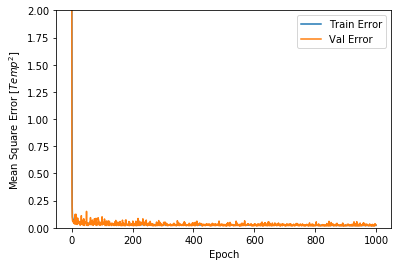

In [198]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

plot_history(history)

In [199]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Temp".format(mae))

Testing set Mean Abs Error:  0.14 Temp


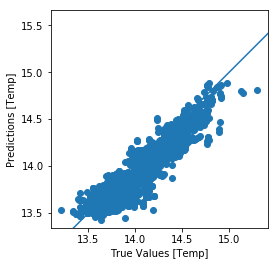

In [200]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Temp]')
plt.ylabel('Predictions [Temp]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0], plt.xlim()[1]])
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

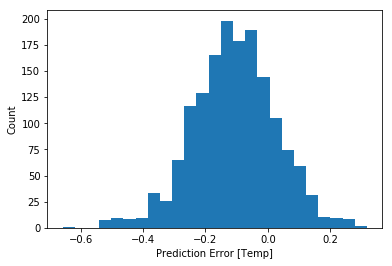

In [201]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Temp]")
_ = plt.ylabel("Count")